In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools

In [2]:
def basis_generator(tot_sites, N_e): # Checked OK

  basis = []

  for combination_indices in itertools.combinations(range(tot_sites), N_e):
    state = [0] * tot_sites
    for index in combination_indices:
      state[index] = 1
    basis.append(state)
  
  return np.array(basis, dtype=np.float64)


def hamiltonian_generator_w_int_diff_V(basis_set, tot_sites, v, w, V1, V2):
  d = len(basis_set)
  H = np.zeros((d, d))

  for i in range(d):
    for j in range(d):
      H[j][i] = np.dot(hamiltonian_on_ket_w_int_diff_V(basis_set[i], tot_sites, v, w, V1, V2), basis_set[j])

  return H


def hamiltonian_on_ket_w_int_diff_V(ket, tot_sites, v, w, V1, V2):
  res = np.zeros((tot_sites), dtype=np.float64)
  for i in range(tot_sites):
    if i % 2 == 0 and i - 1 > 0:
      if ket[i - 1] == 1:
        res[i] += w
        if ket[i] == 1:
          res[i] += V2
      if ket[i + 1] == 1:
        res[i] += v
        if ket[i] == 1:
          res[i] += V1
    elif i % 2 == 1 and i + 1 < tot_sites:
      if ket[i - 1] == 1:
        res[i] += v
        if ket[i] == 1:
          res[i] += V1
      if ket[i + 1] == 1:
        res[i] += w
        if ket[i] == 1:
          res[i] += V2
    elif i == 0 and ket[i + 1] == 1:
      res[i] += v
      if ket[i] == 1:
          res[i] += V1
    elif i == tot_sites - 1 and ket[i - 1] == 1:
      res[i] += v
      if ket[i] == 1:
          res[i] += V1
  return res # normalize(res)


def normalize(vec):
  norm = np.linalg.norm(vec)
  if norm == 0:
    return vec
  return vec / norm

In [6]:
N = 2
w = 0
v = 0
V1 = 1
V2 = 2
tot_sites = 2 * N
N_e = N

basis_set = basis_generator(tot_sites, N_e)

for i in range(len(basis_set)):
    ket = basis_set[i]
    print(f'{ket} ------ {hamiltonian_on_ket_w_int_diff_V(ket, tot_sites, v, w, V1, V2)}')

hamiltonian = hamiltonian_generator_w_int_diff_V(basis_set, tot_sites, v, w, V1, V2)

print(hamiltonian)
print(sp.linalg.ishermitian(hamiltonian))


print((hamiltonian + hamiltonian.transpose())/2)
print(sp.linalg.ishermitian((hamiltonian + hamiltonian.transpose())/2))

# e_val_arr, e_vec_arr = np.linalg.eigh(hamiltonian)

# for e_val in e_val_arr:
#     print(e_val)
  
# print(e_vec_arr)

[1. 1. 0. 0.] ------ [1. 1. 0. 0.]
[1. 0. 1. 0.] ------ [0. 0. 0. 0.]
[1. 0. 0. 1.] ------ [0. 0. 0. 0.]
[0. 1. 1. 0.] ------ [0. 2. 2. 0.]
[0. 1. 0. 1.] ------ [0. 0. 0. 0.]
[0. 0. 1. 1.] ------ [0. 0. 1. 1.]
[[2. 0. 0. 2. 0. 0.]
 [1. 0. 0. 2. 0. 1.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 4. 0. 1.]
 [1. 0. 0. 2. 0. 1.]
 [0. 0. 0. 2. 0. 2.]]
False
[[2.  0.5 0.5 1.5 0.5 0. ]
 [0.5 0.  0.  1.  0.  0.5]
 [0.5 0.  0.  0.  0.  0.5]
 [1.5 1.  0.  4.  1.  1.5]
 [0.5 0.  0.  1.  0.  0.5]
 [0.  0.5 0.5 1.5 0.5 2. ]]
True


Time taken: 0:00:02.677083


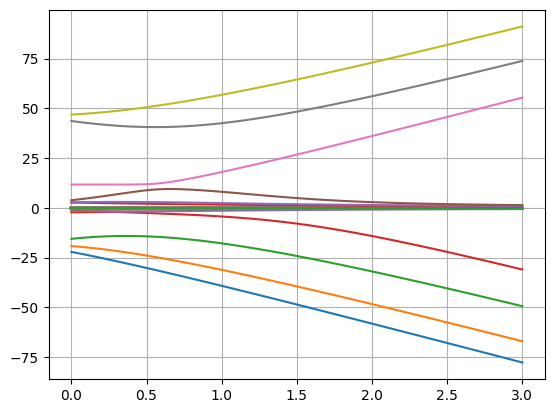

In [21]:
'''
There are multiple electrons in the system
This code if for only a single value of "w" and multiple values of "v"
N : number of unit cells
tot_sites : Total sites in the system
N_e : number of electrons in the system
'''
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools as itr
import h5py
import os
from datetime import datetime
from functions import *


v_step_no = 101
v_0 = 0
v_end = 3
v_arr = np.linspace(v_0, v_end, v_step_no)
v_arr = np.around(v_arr, decimals=3)
w = 1
N = 4
tot_sites = 2 * N
N_e = N
v1 = 1
v2 = 2
topo_state_no = 2

start_time = datetime.now()



all_e_val_arr = []
topo_state_pos_sp_arr = np.zeros((v_step_no, topo_state_no, tot_sites))

for k, v in enumerate(v_arr):
    topo_state_arr = []
    topo_state_arr_idx_arr = []

    basis_set = basis_generator(tot_sites, N_e)
    hamiltonian = hamiltonian_generator_w_int_diff_V(basis_set, tot_sites, v, w, v1, v2)
    hamiltonian = (hamiltonian + hamiltonian.transpose())/2

    dim = len(hamiltonian)

    e_val_arr, e_vec_arr = np.linalg.eigh(hamiltonian)

    all_e_val_arr.append(e_val_arr)

    e_val_arr_abs = np.abs(e_val_arr)

    e_val_arr_abs_sorted = np.sort(e_val_arr_abs)

    for i in range(topo_state_no):
        topo_state_arr_idx_arr.append((e_val_arr_abs == e_val_arr_abs_sorted[i]).argmax())

    for i in topo_state_arr_idx_arr:
        topo_state_arr.append(e_vec_arr[:, i])
    
    for i, state in enumerate(topo_state_arr):
        for j, element in enumerate(state):
            topo_state_pos_sp_arr[k][i] += element * basis_set[j]
        topo_state_pos_sp_arr[k][i] = normalize(topo_state_pos_sp_arr[k][i])

all_e_val_arr = np.array(all_e_val_arr)

end_time = datetime.now()
time_taken = end_time - start_time
print(f"Time taken: {time_taken}")

# final_e_val_arr = 


for i, e_v_arr in enumerate(all_e_val_arr.transpose()[0:]):
    if i != len(all_e_val_arr.transpose()) - 1:
        plt.plot(v_arr, e_v_arr)
# plt.legend()
plt.grid()
plt.show()


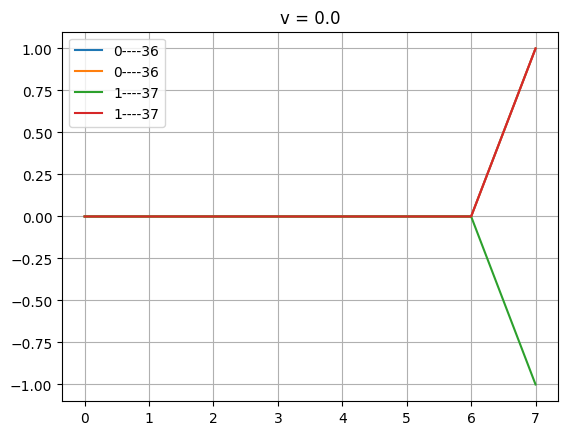

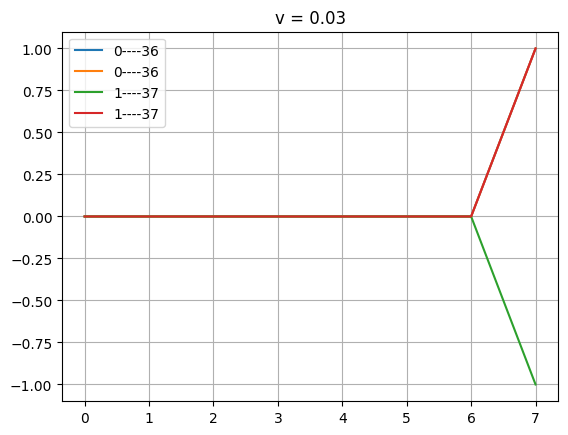

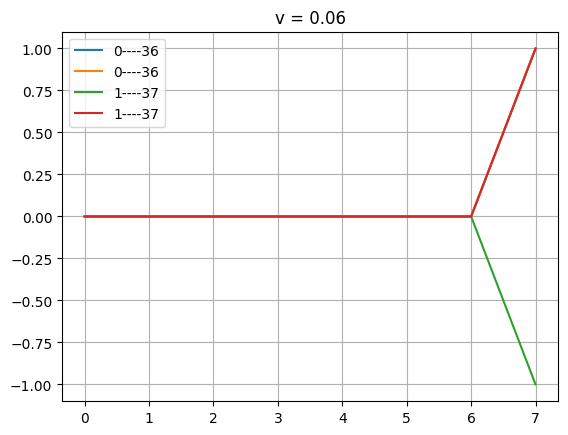

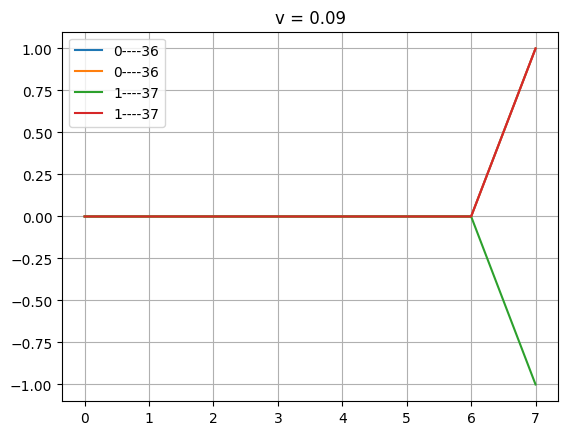

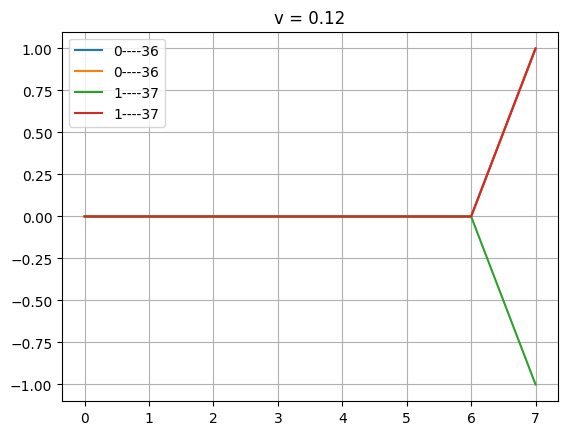

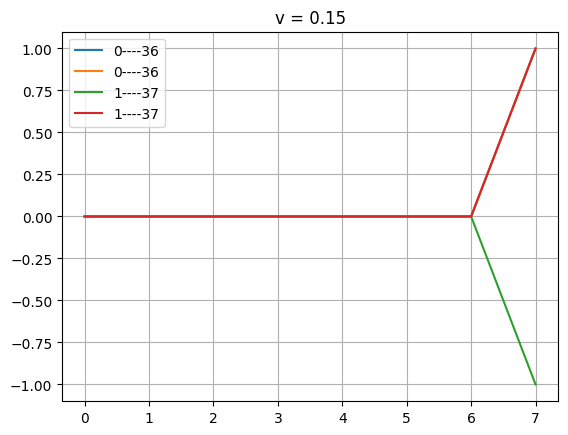

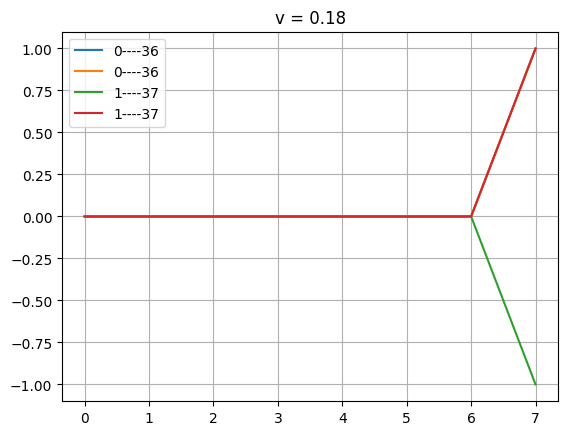

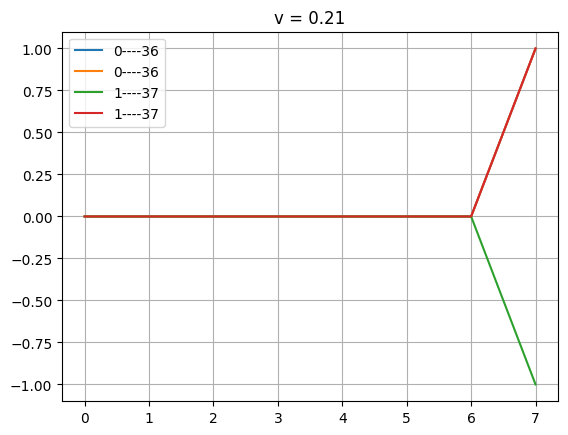

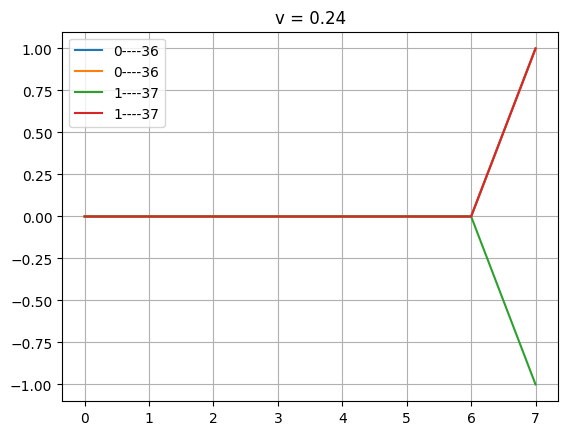

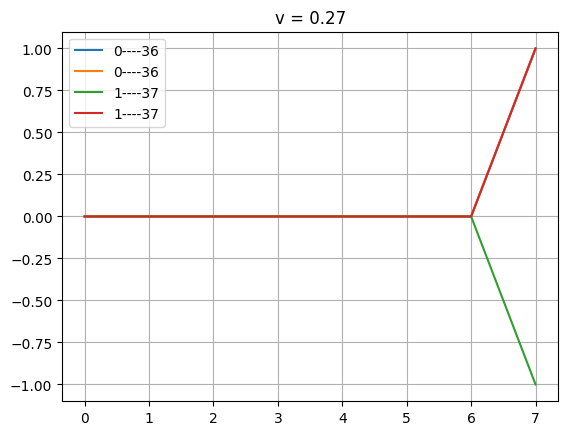

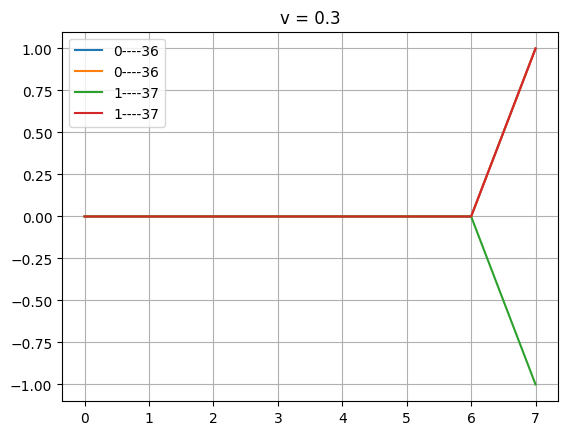

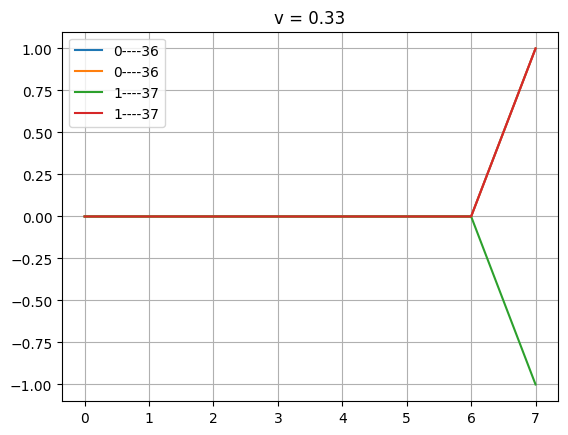

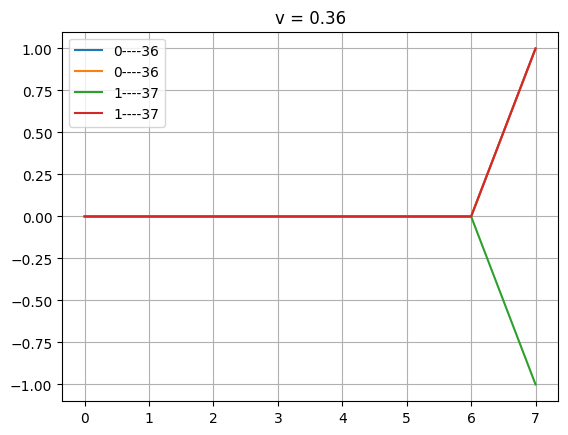

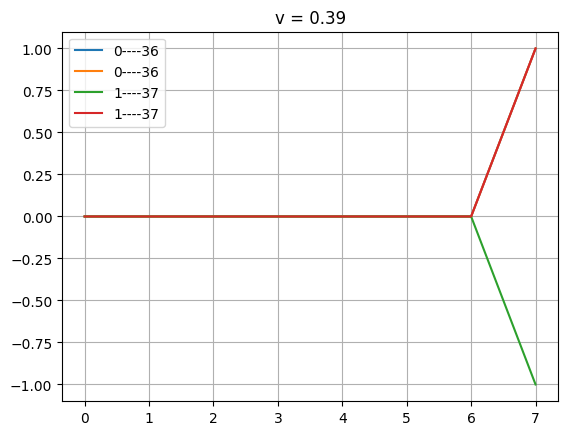

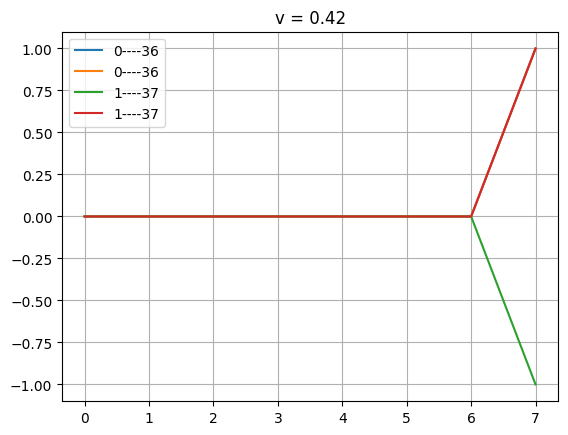

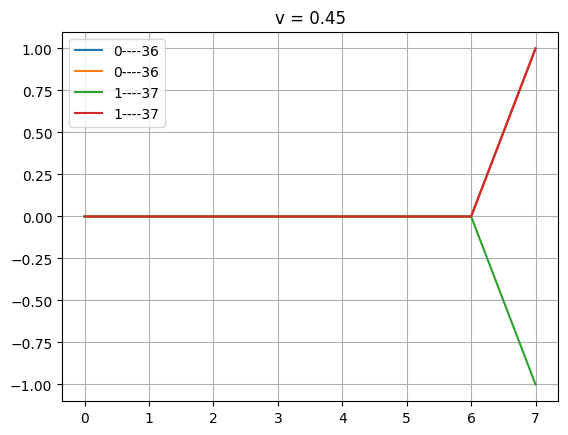

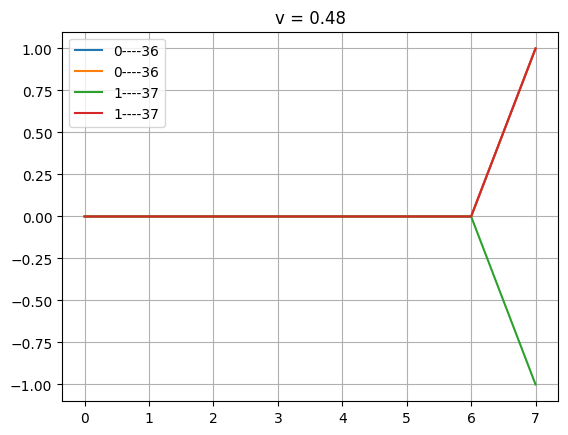

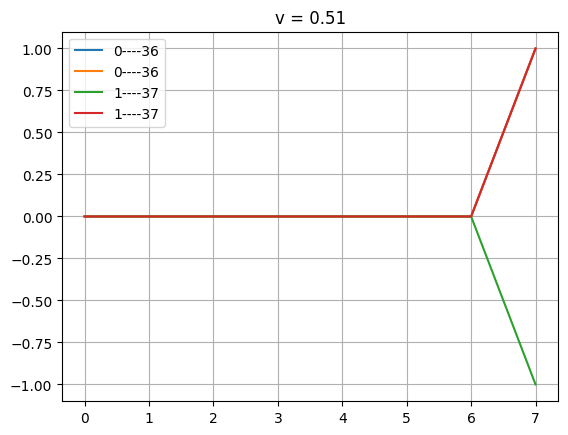

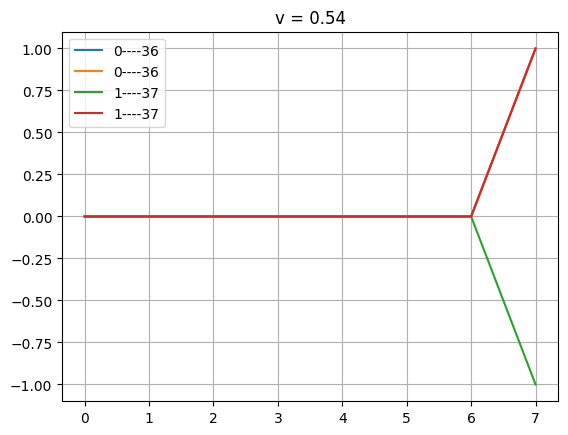

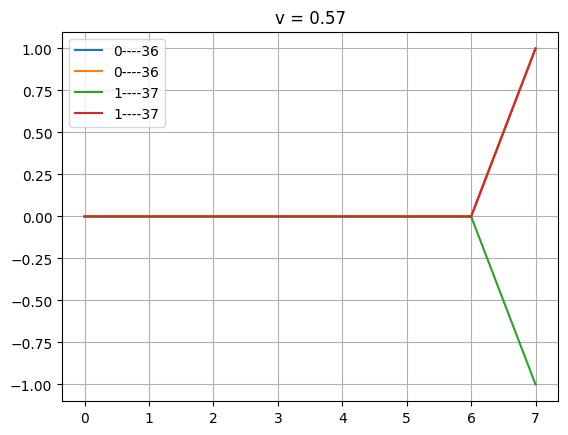

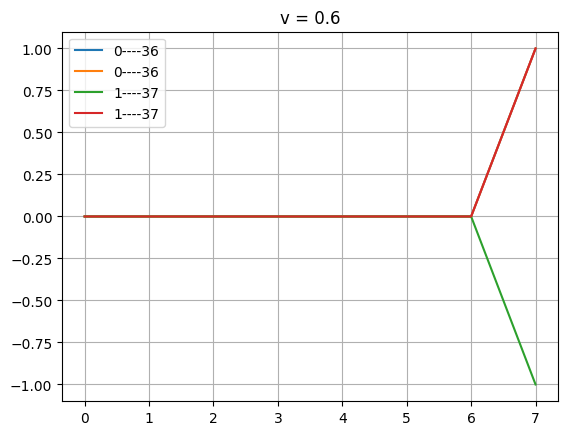

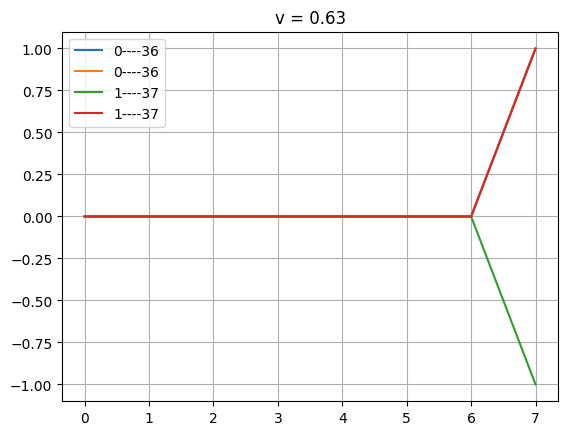

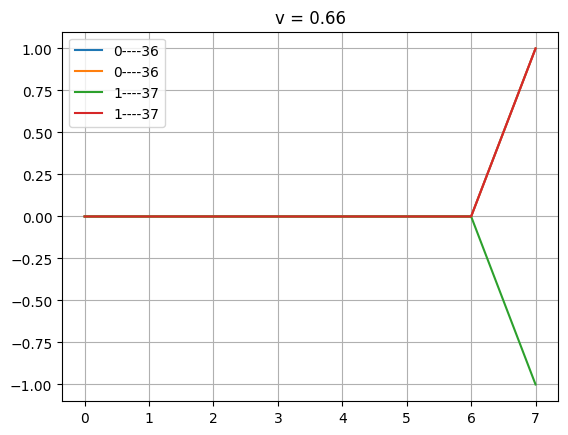

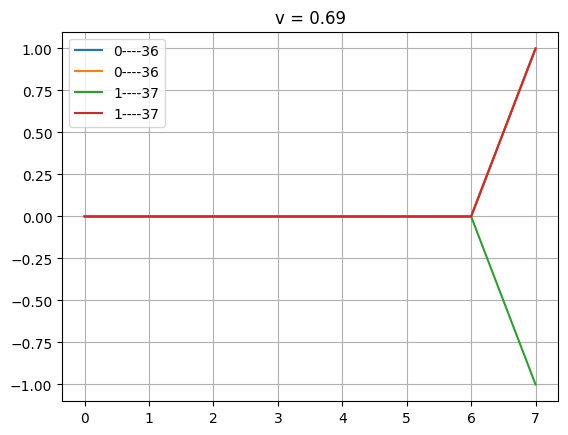

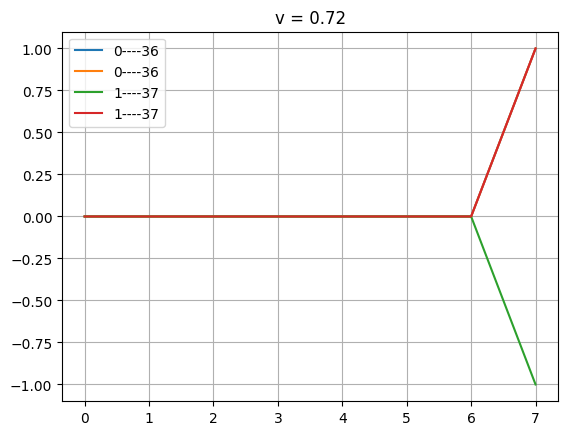

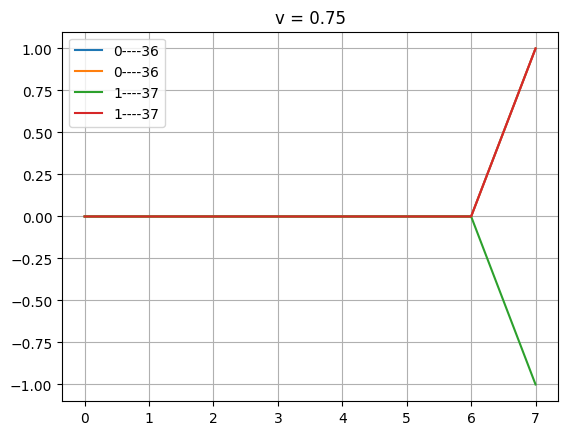

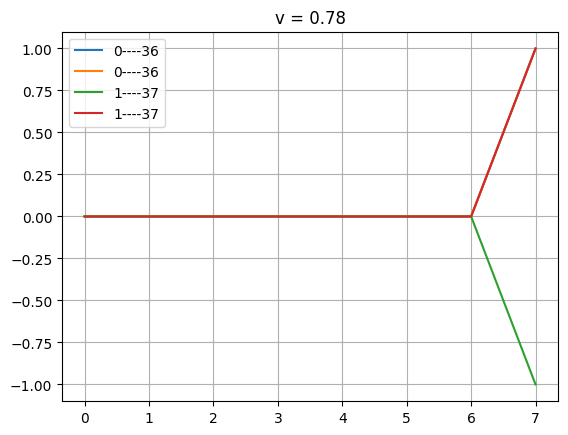

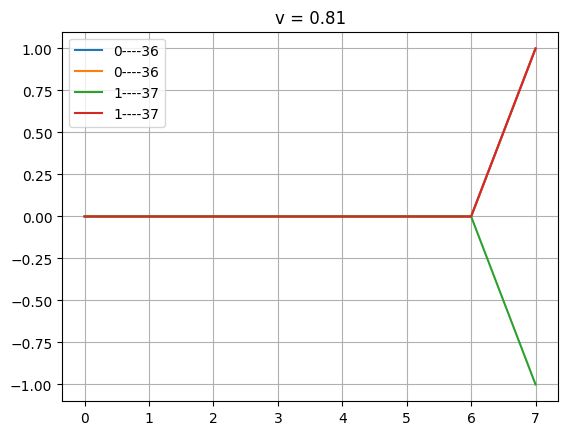

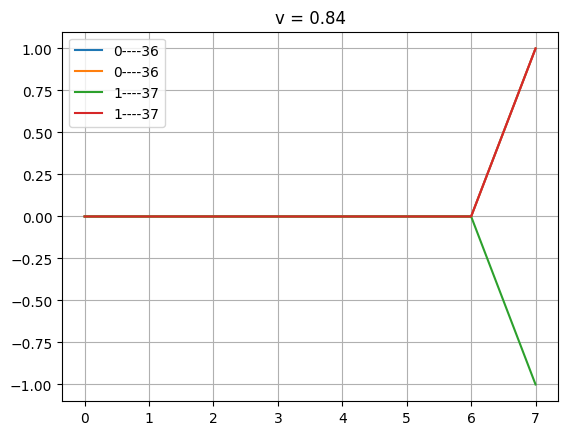

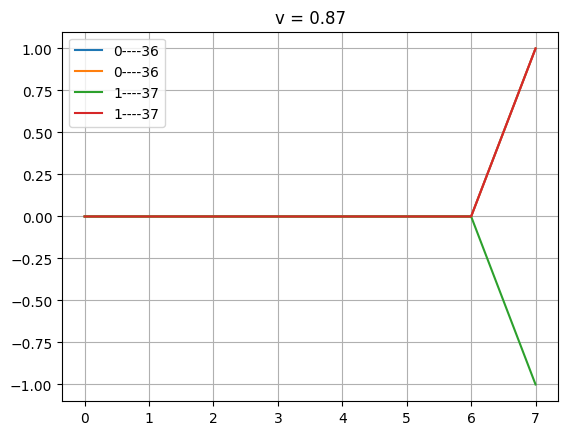

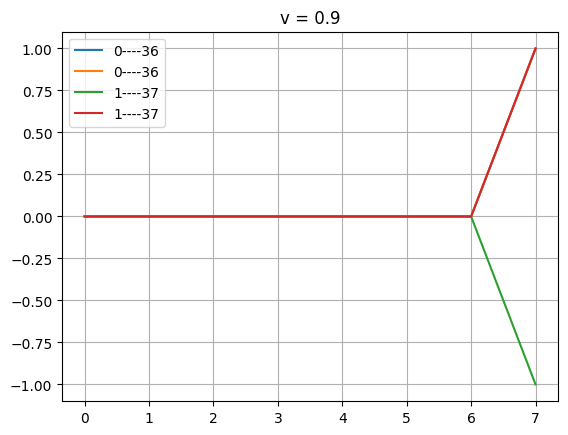

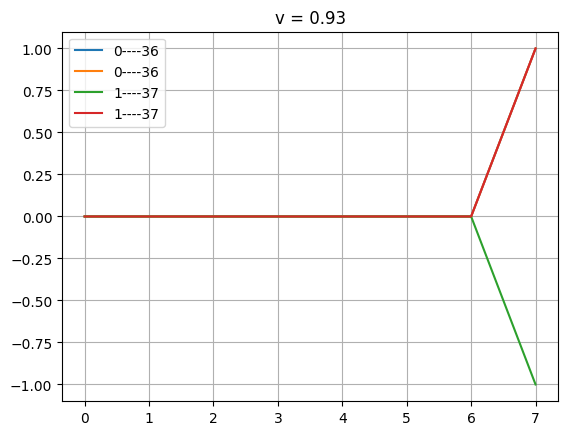

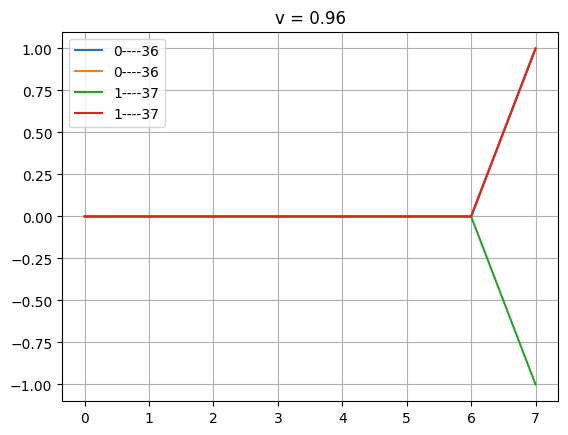

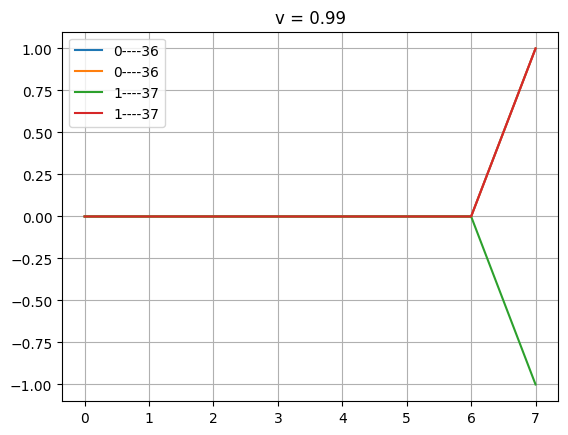

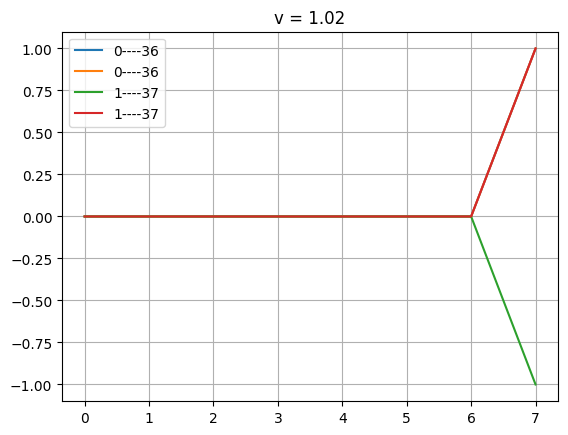

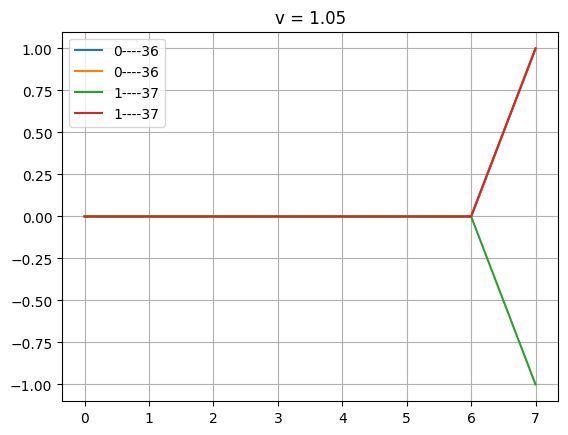

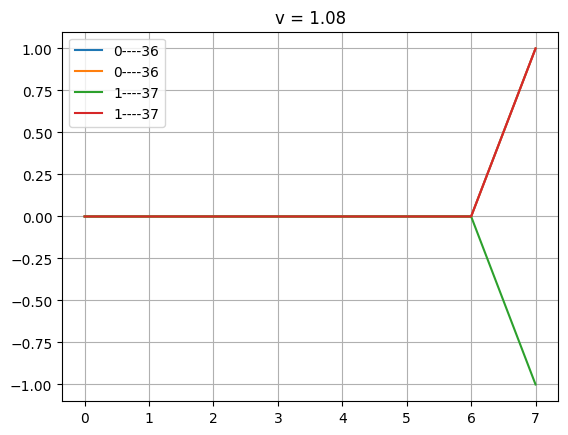

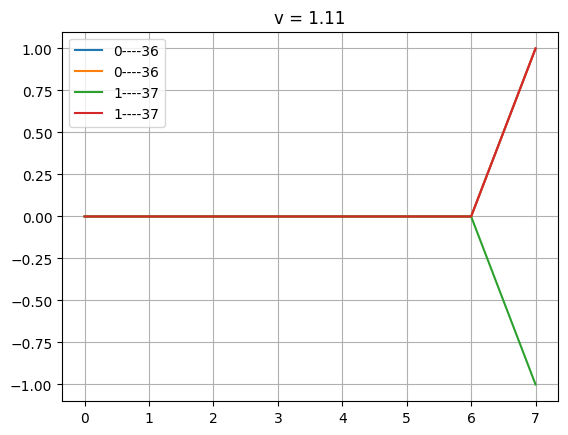

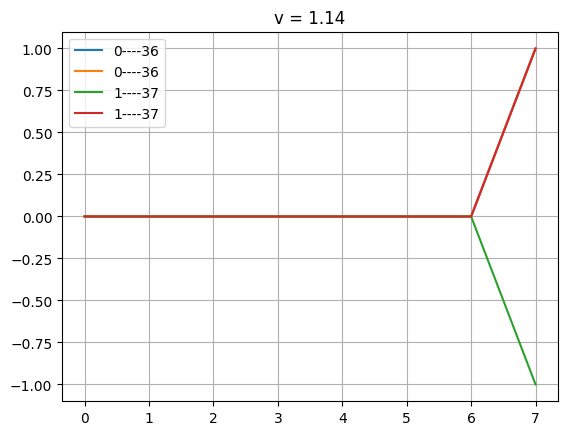

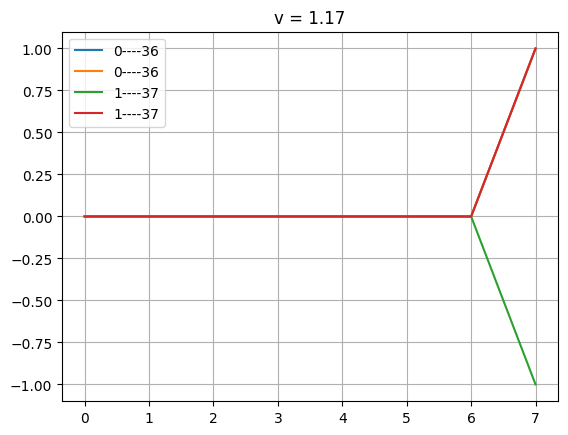

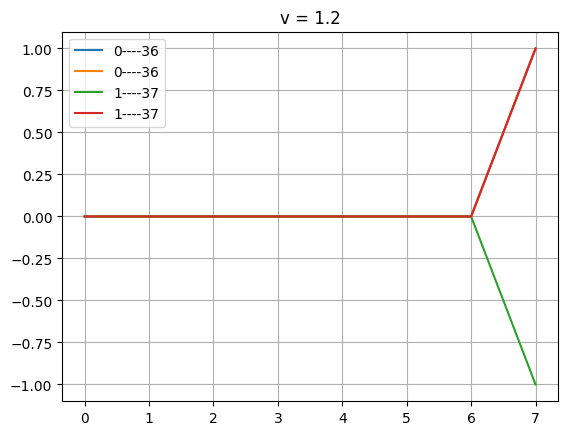

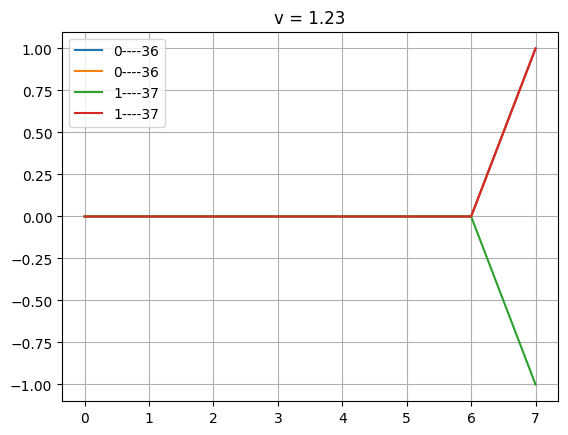

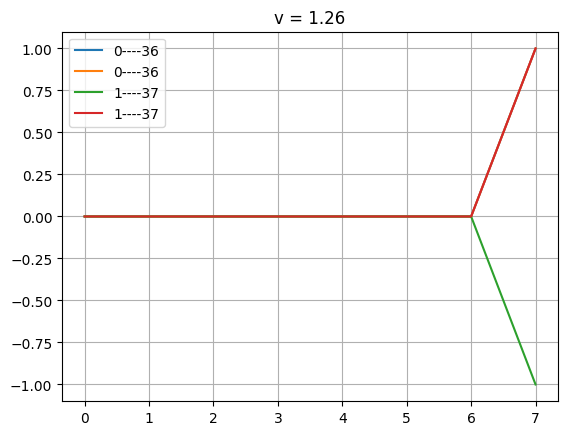

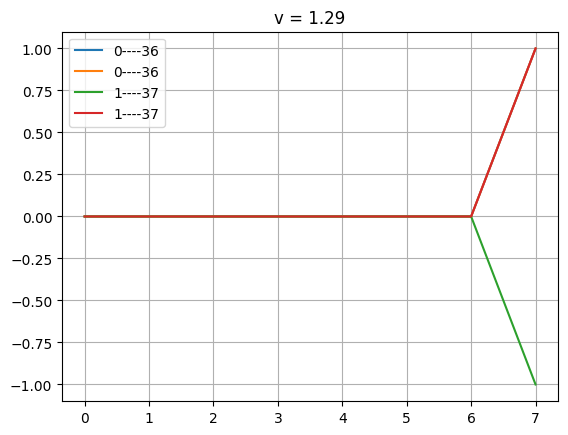

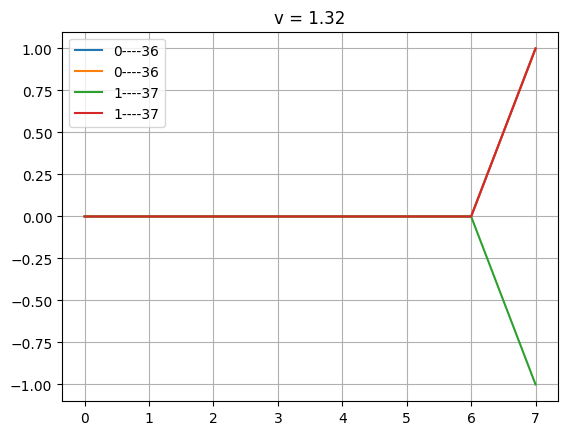

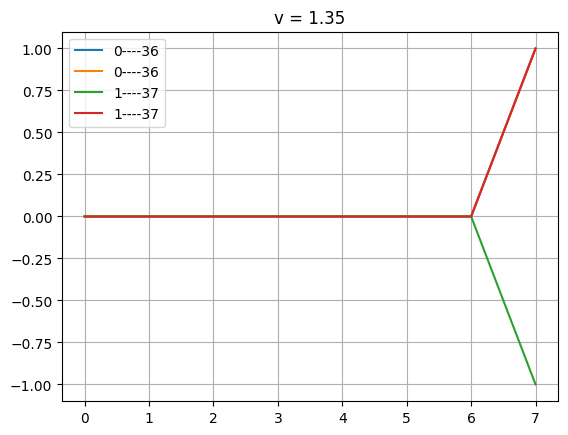

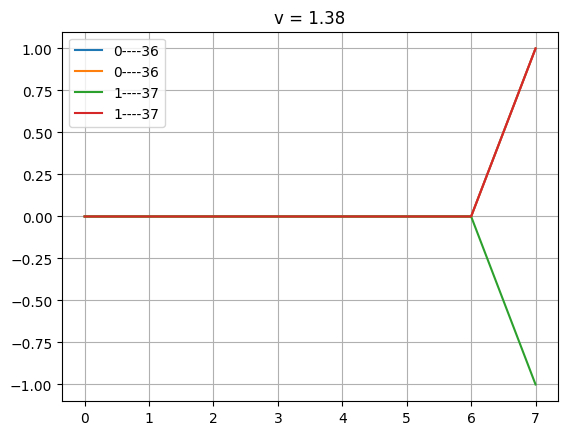

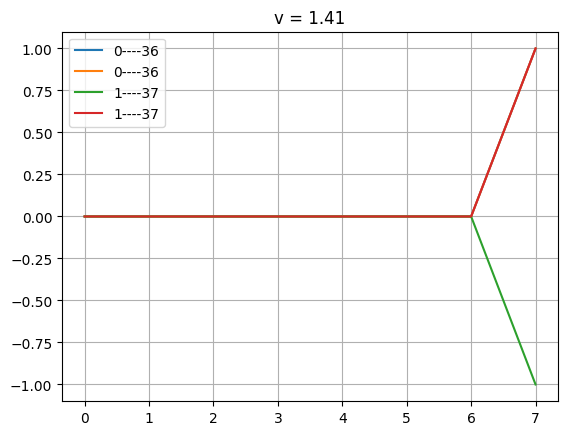

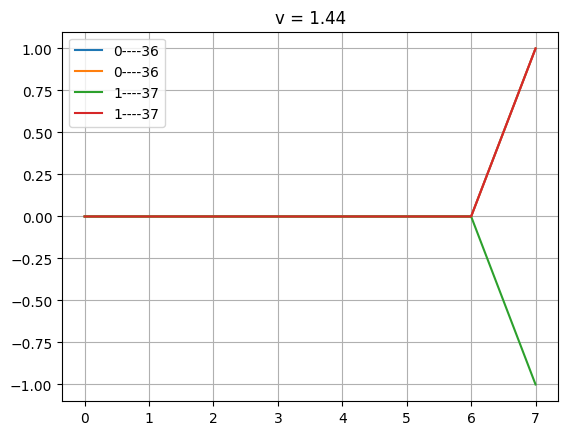

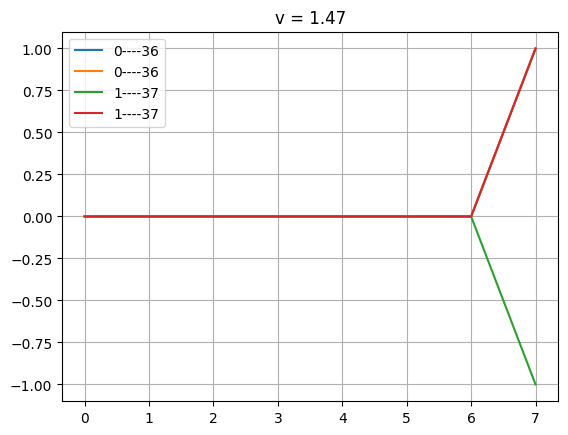

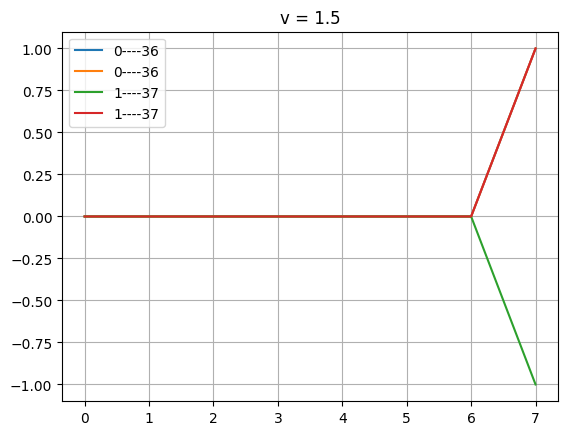

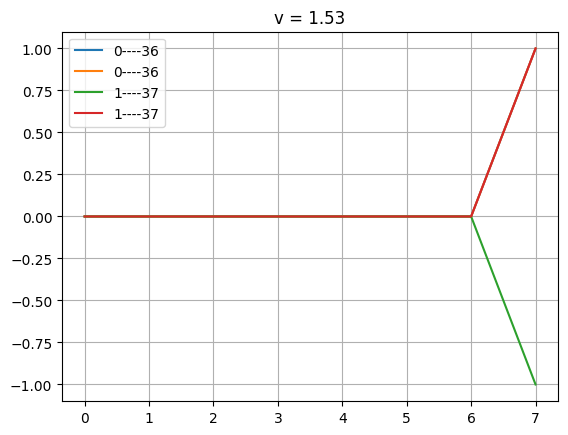

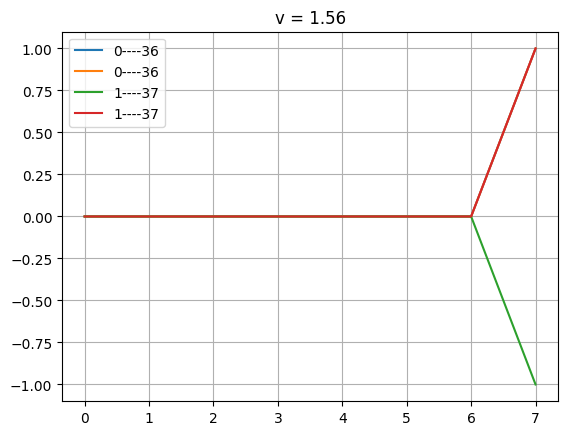

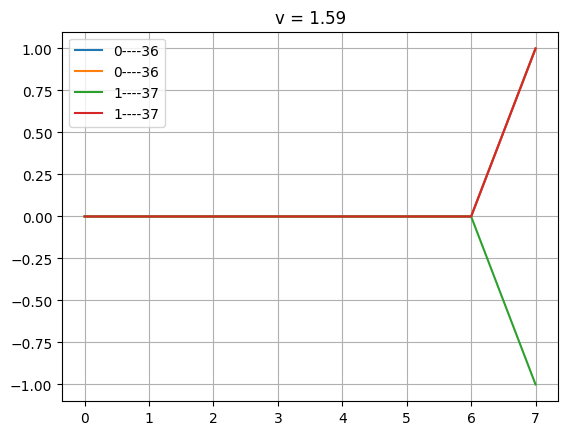

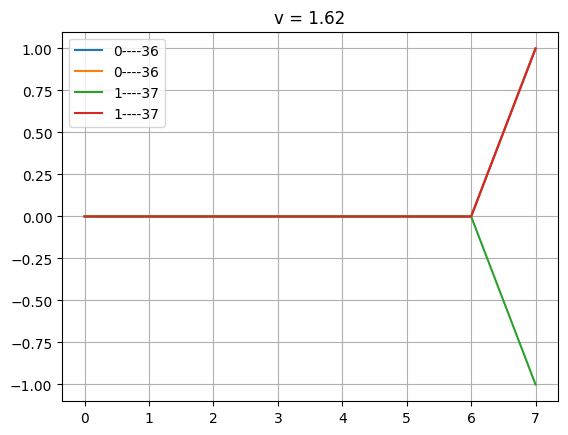

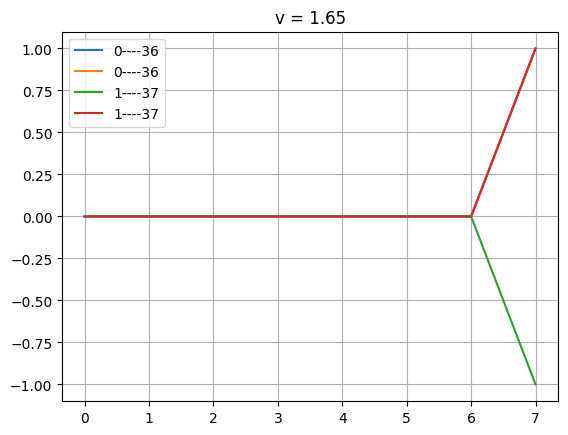

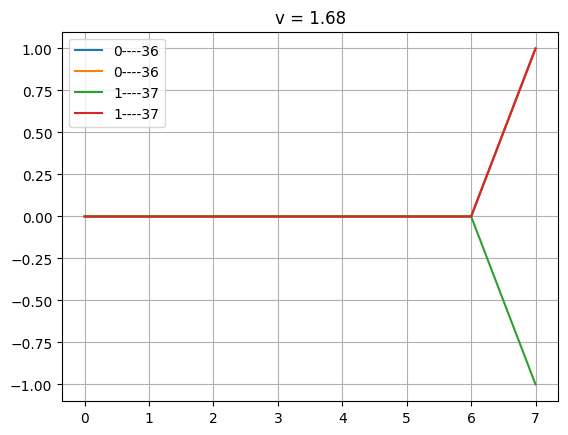

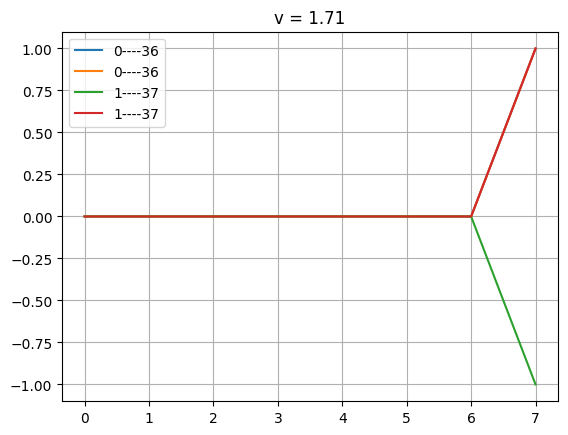

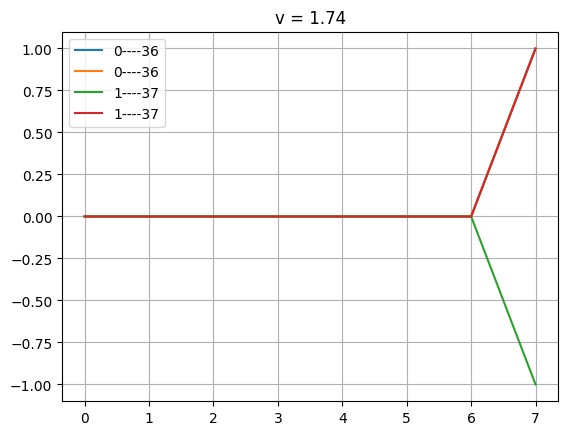

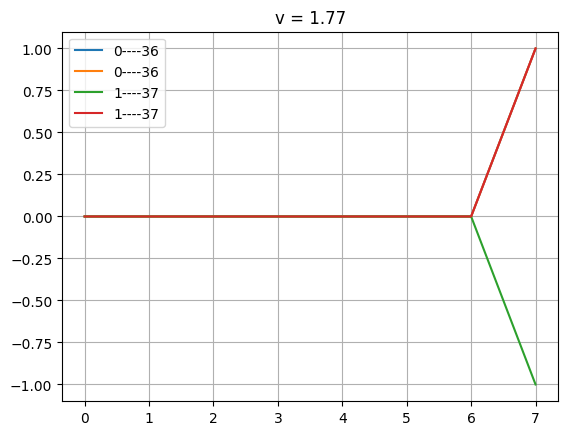

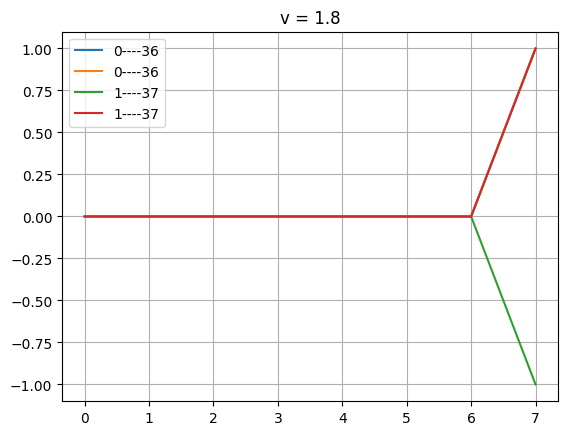

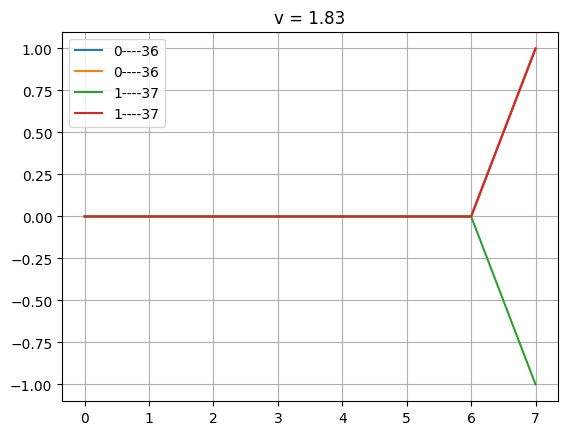

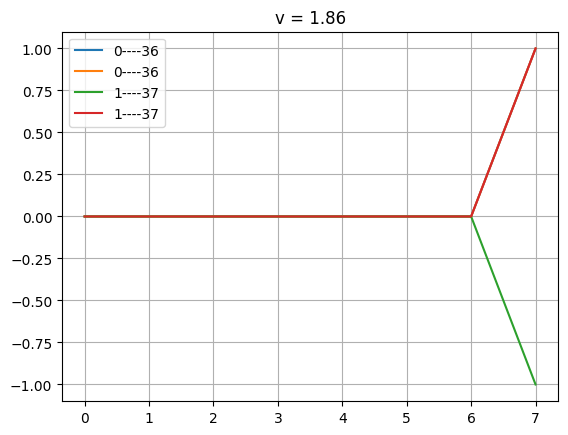

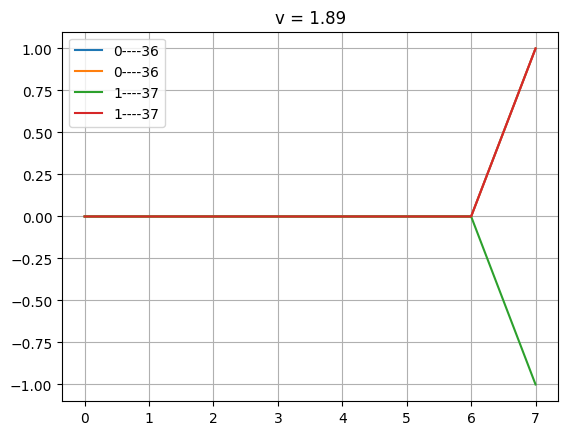

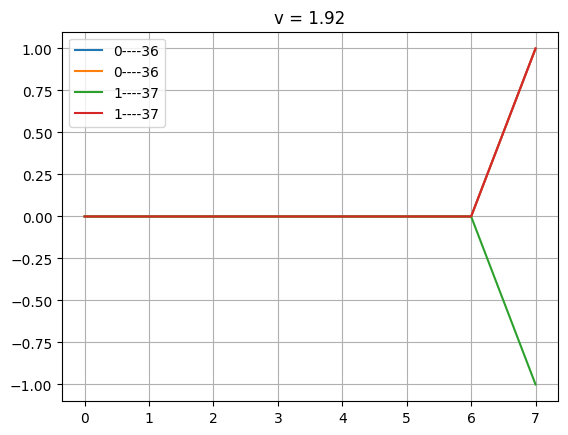

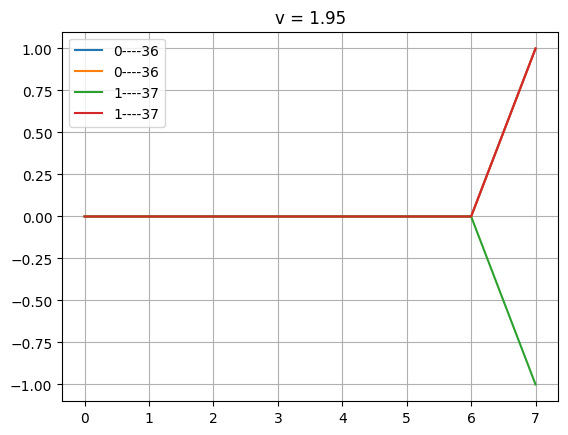

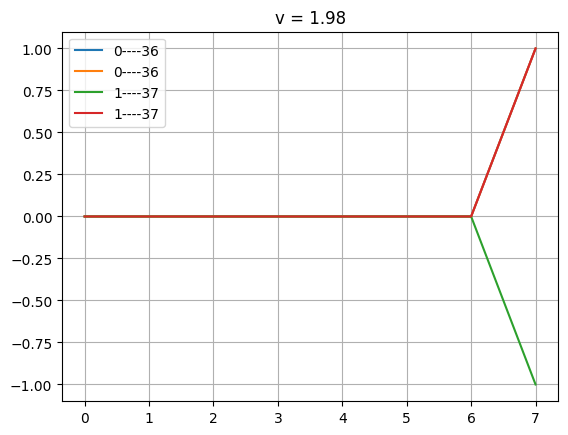

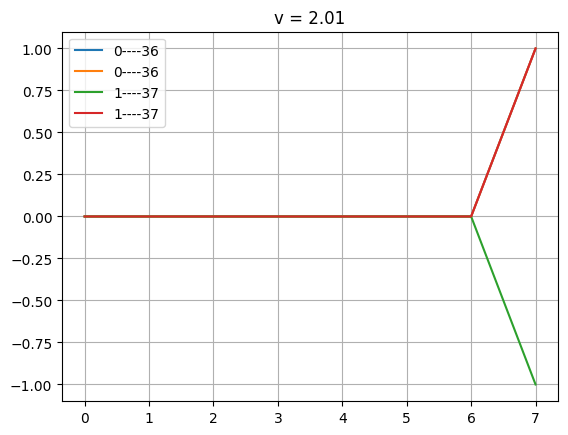

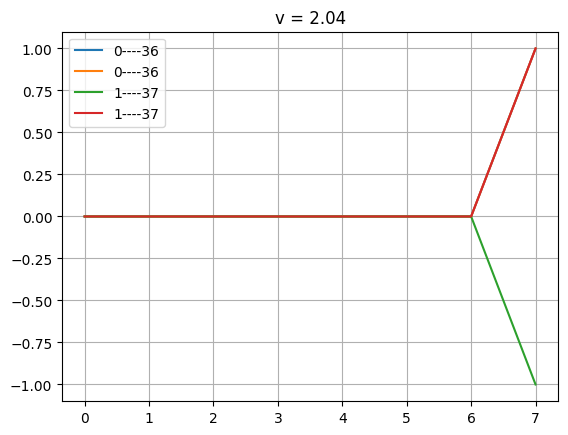

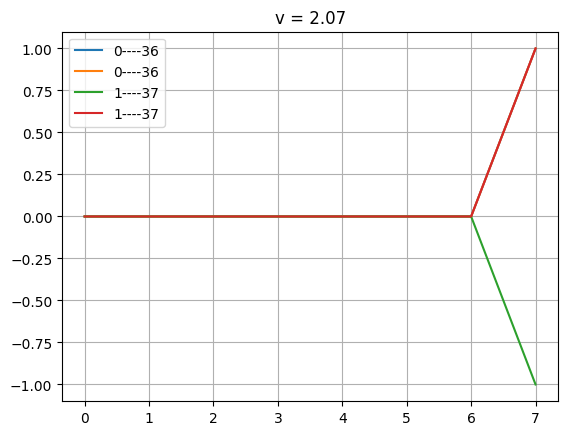

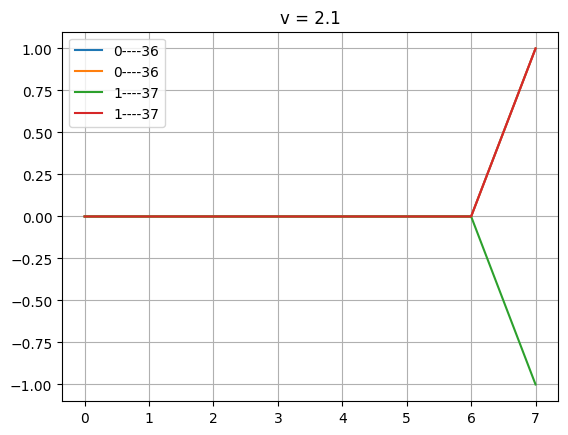

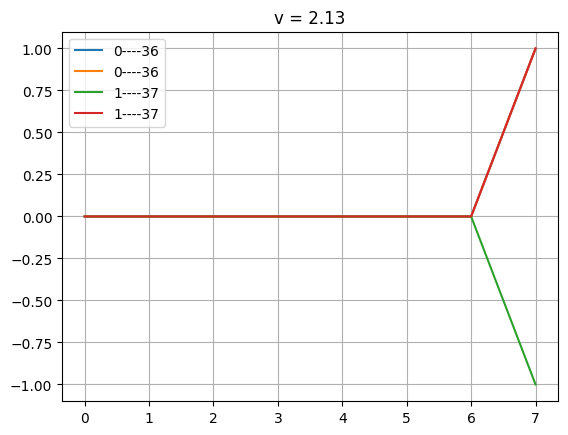

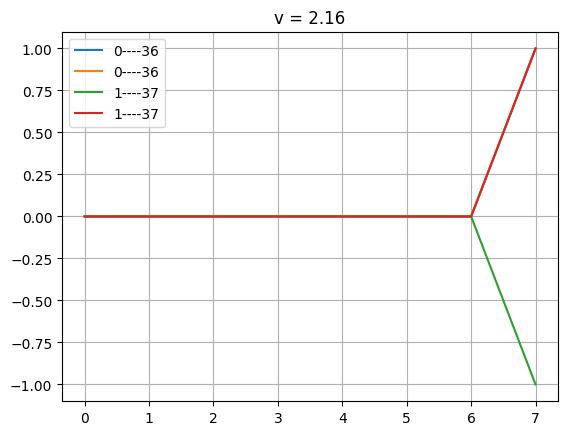

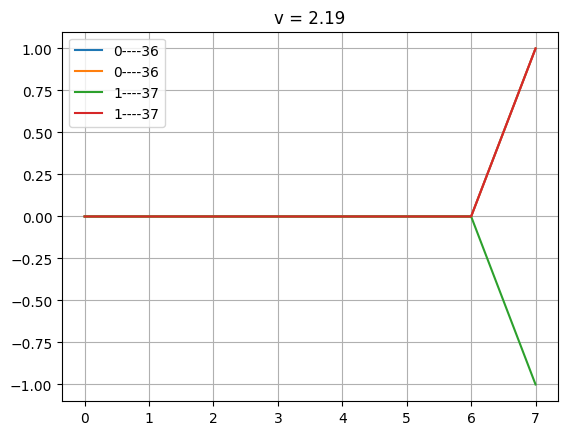

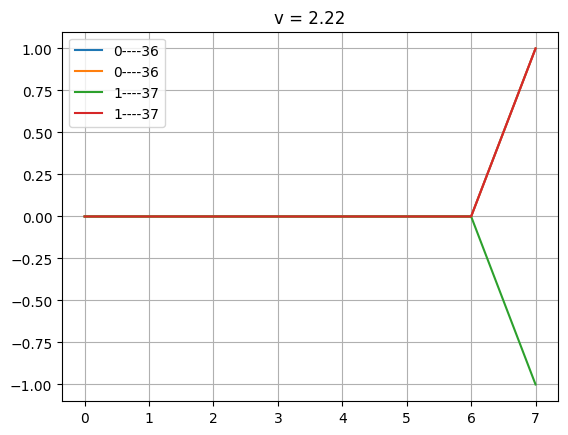

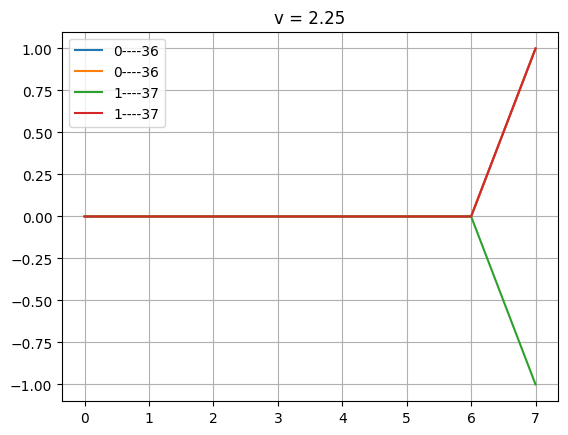

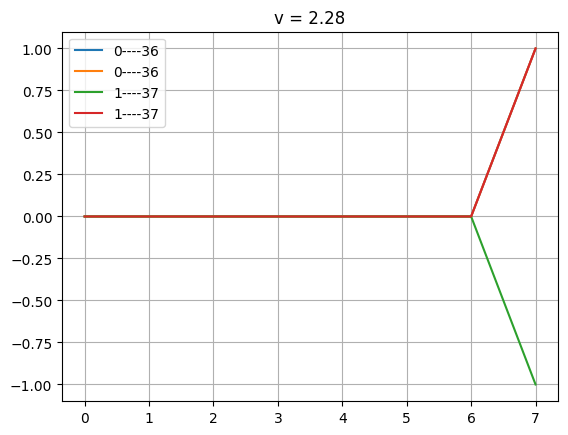

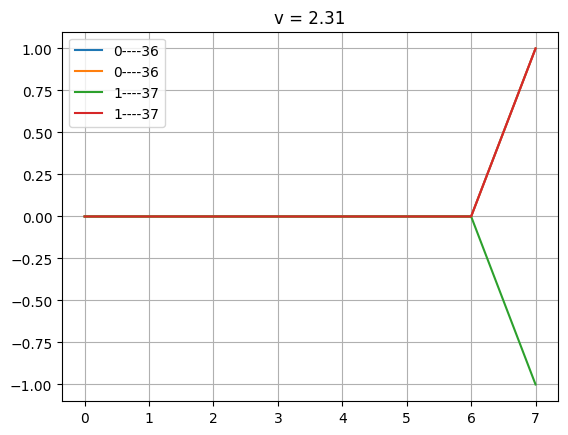

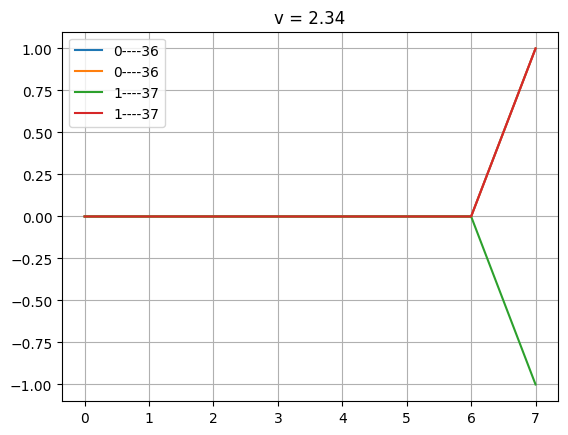

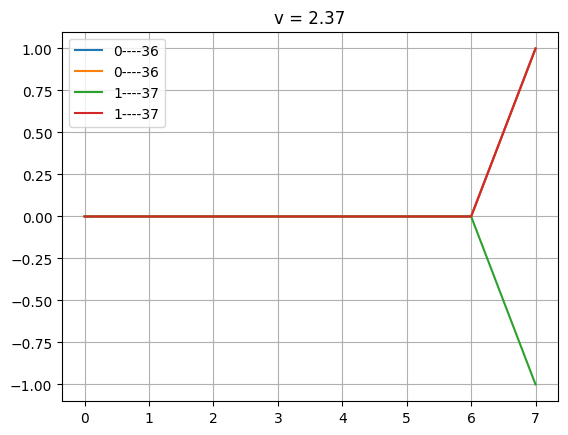

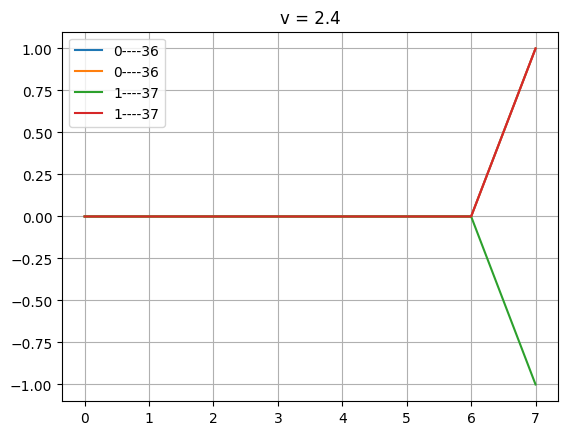

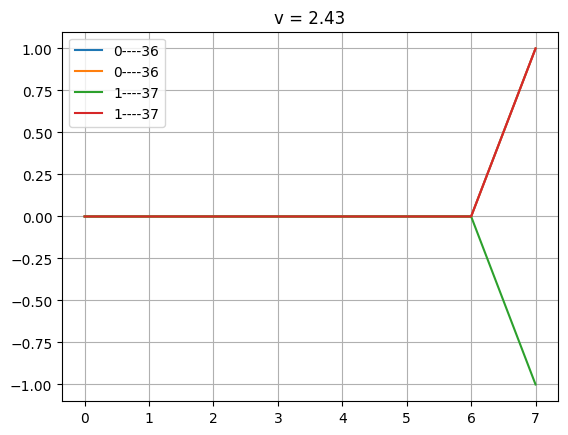

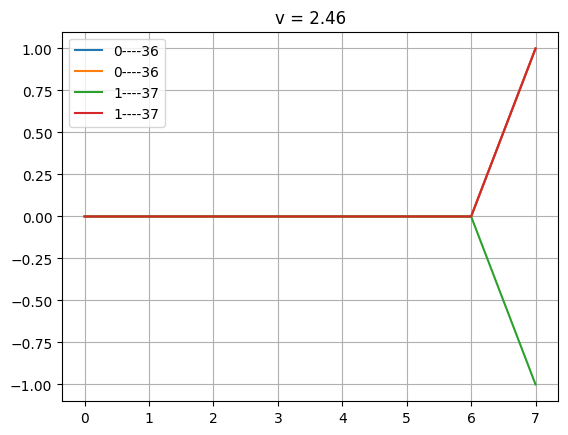

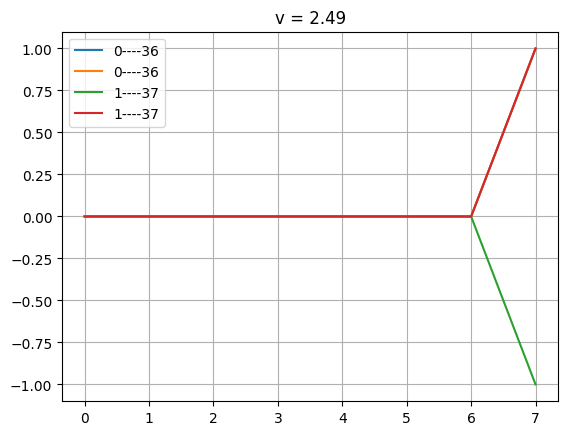

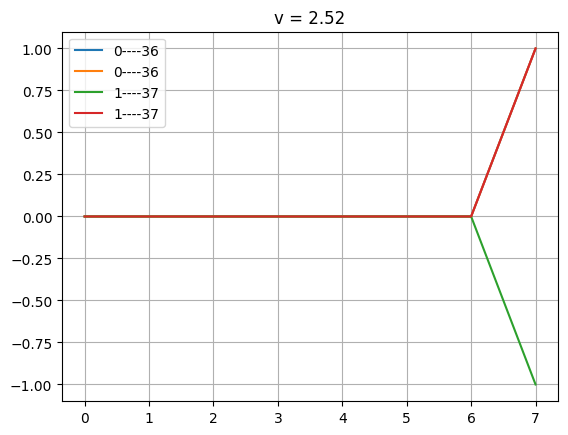

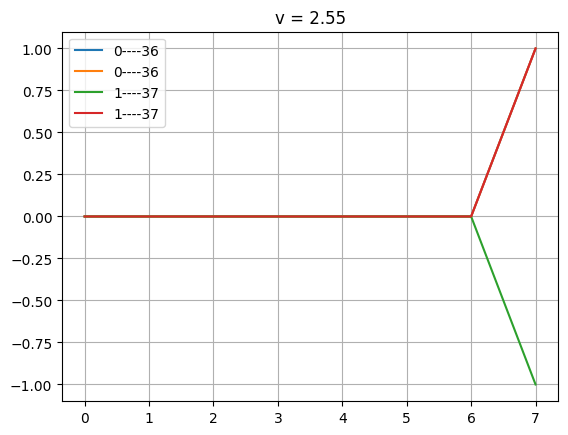

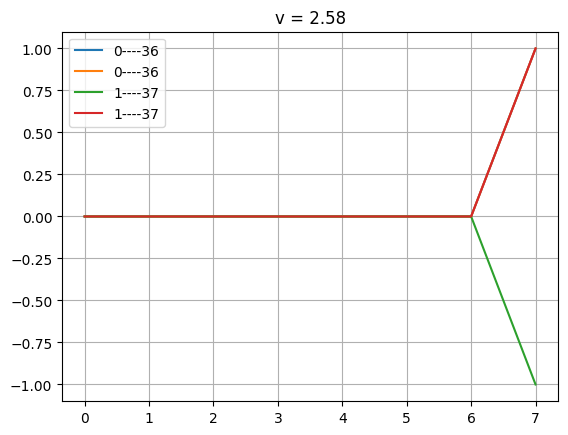

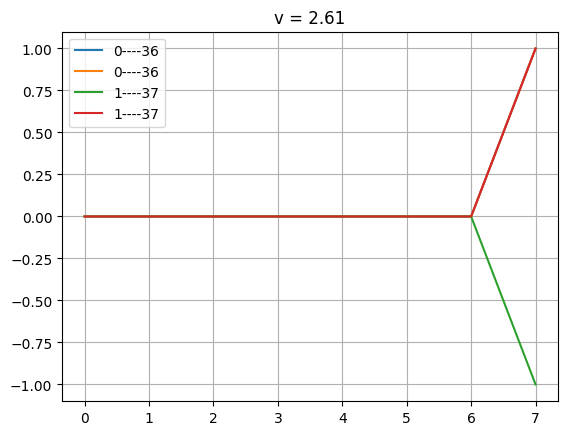

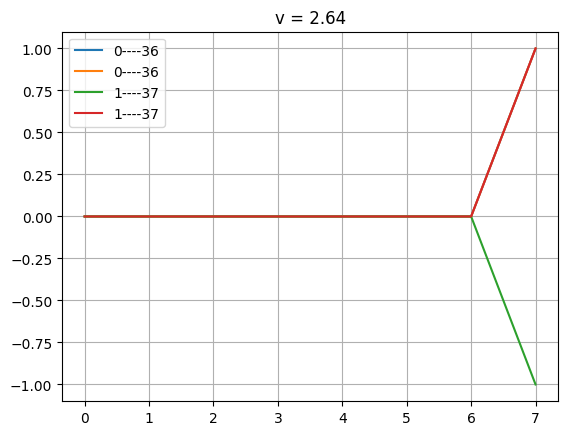

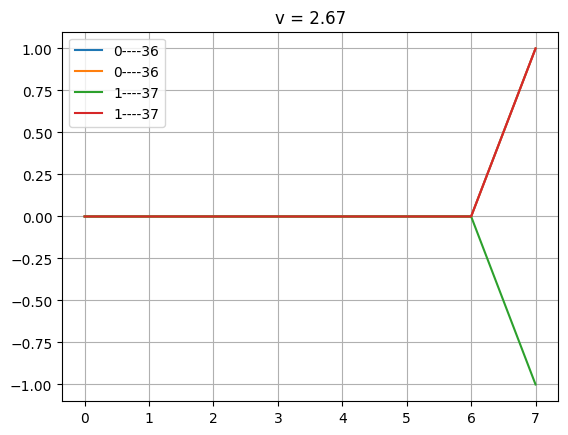

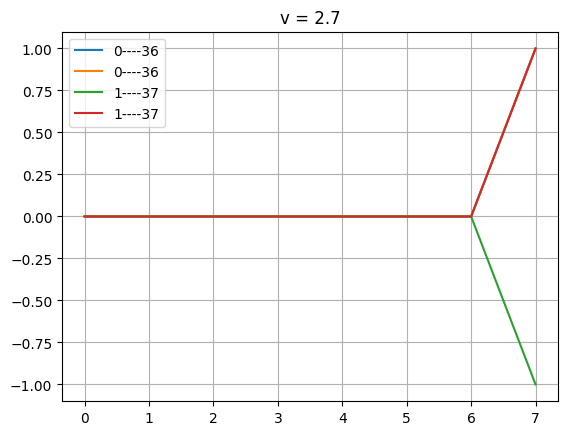

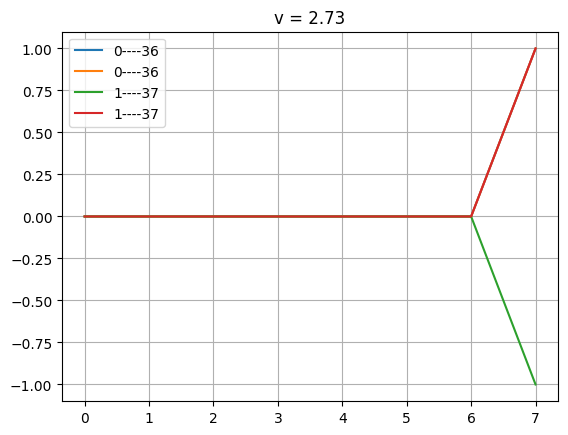

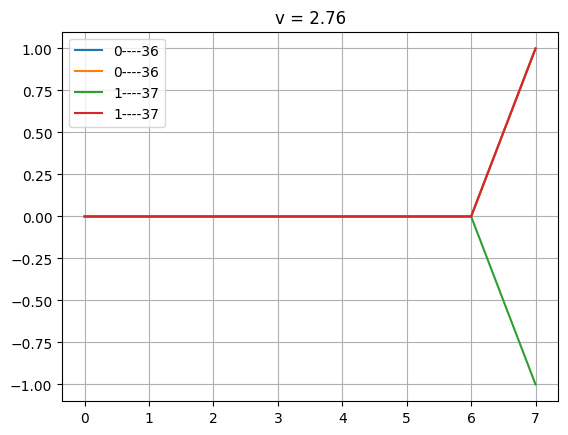

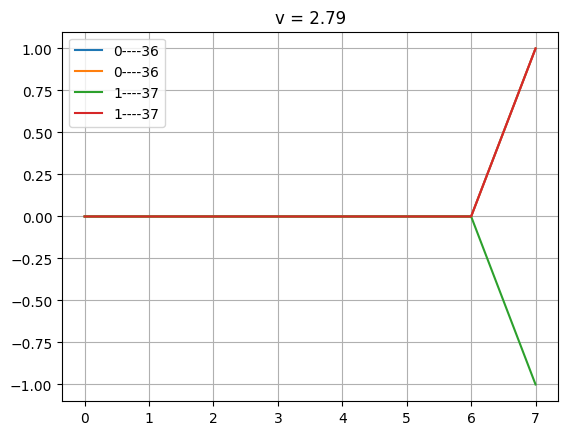

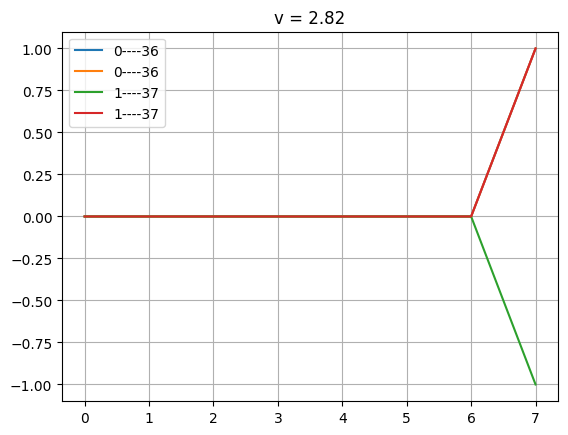

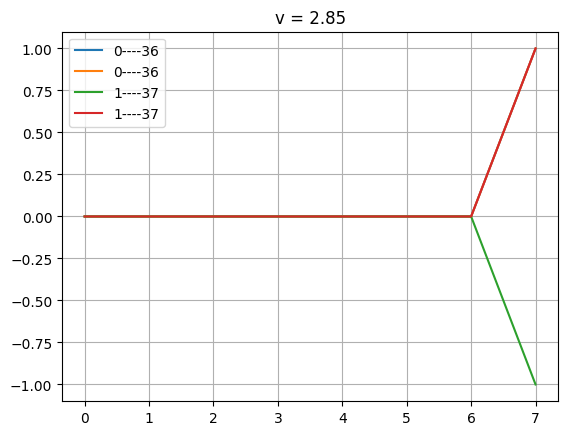

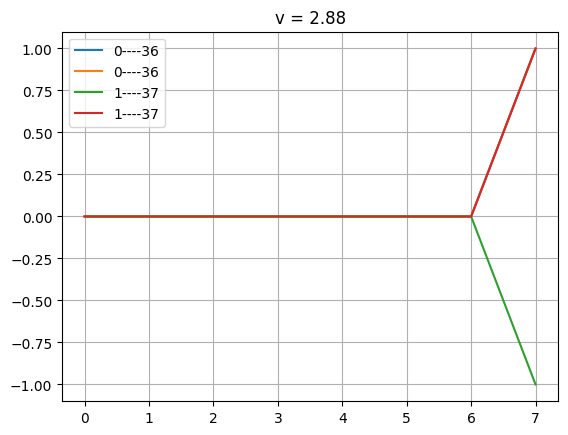

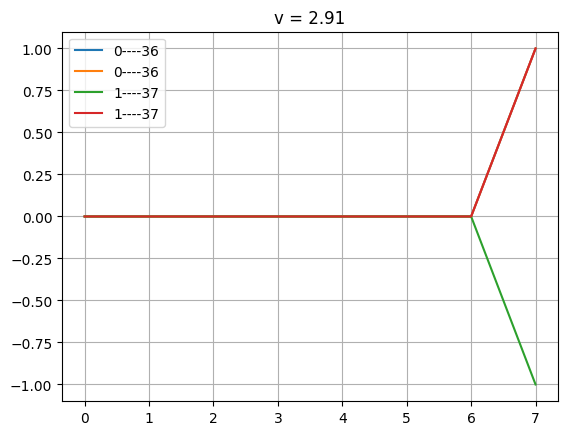

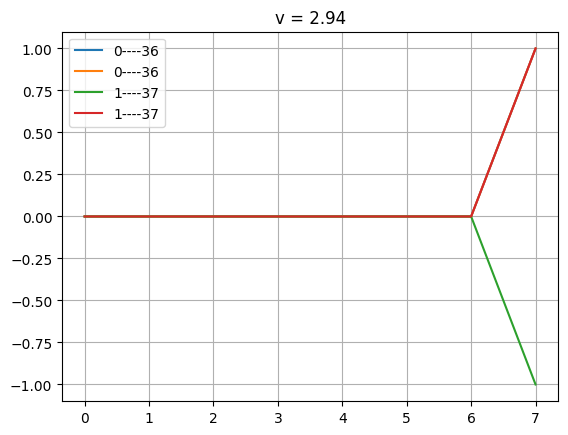

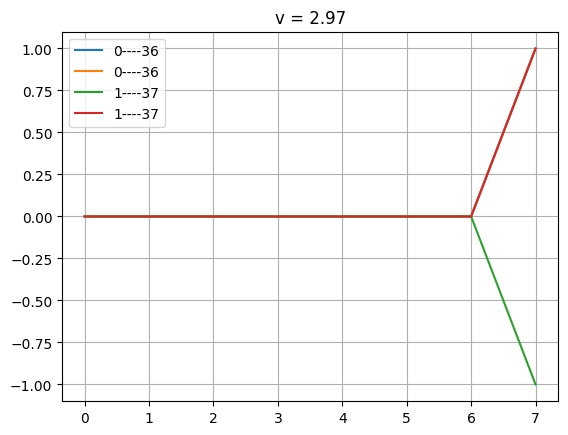

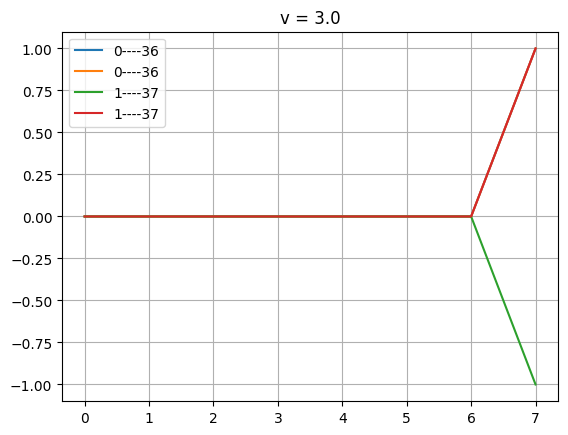

In [23]:
sites_arr = np.arange(tot_sites)
for j in range(v_step_no):
    for i, wf in enumerate(topo_state_pos_sp_arr[10]):
        plt.plot(sites_arr, wf, label=f'{i}----{topo_state_arr_idx_arr[i]}')
        plt.plot(sites_arr, wf**2, label=f'{i}----{topo_state_arr_idx_arr[i]}')
    plt.title(f"v = {v_arr[j]}")
    plt.legend()
    plt.grid()
    plt.show()
# sites_arr = np.arange(tot_sites)
# for i, wf in enumerate(topo_state_pos_sp_arr[10]):
#     plt.plot(sites_arr, wf**2, label=f'{i}----{topo_state_arr_idx_arr[i]}')
# plt.legend()
# plt.grid()
# plt.show()